In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
features = pd.read_csv('meta_features.csv')
ranking  = pd.read_csv('ranking_fs.csv')

## Preprocessing

In [22]:
# TODO: after split
from sklearn.preprocessing import StandardScaler
dataset = StandardScaler().fit_transform(features.iloc[:, 1:])

In [23]:
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
trn_idx, val_idx = next(kfolds.split(features))

In [24]:
from matrix_factorization.utils import get_dataset
dataset_trn, ranker_trn, target_trn = get_dataset(dataset[trn_idx], 
                                                ranking.iloc[trn_idx])
dataset_val, ranker_val, target_val = get_dataset(dataset[val_idx],
                                                ranking.iloc[val_idx])

In [166]:
from matrix_factorization.utils import RankerDataset
from torch.utils.data import DataLoader
trn_ds = RankerDataset(dataset_trn, ranker_trn, target_trn)
val_ds = RankerDataset(dataset_val, ranker_val, target_val)
trn_dl = DataLoader(trn_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds)

In [223]:
from matrix_factorization.utils import RankerNet
model = RankerNet(dataset_sz=39, ranker_sz=3, latent_sz=10)

In [224]:
import torch.nn as nn
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [225]:
from matrix_factorization.utils import train_model
train_losses, val_losses = train_model(model, trn_dl, optimizer, criterion, 200, 
                           val_loader=val_dl)

Train Epoch: 1 [20/162 (91%)]	Loss: 0.531541	Val Loss: 0.624293
Train Epoch: 2 [20/162 (91%)]	Loss: 0.544627	Val Loss: 0.623130
Train Epoch: 3 [20/162 (91%)]	Loss: 0.516462	Val Loss: 0.623254
Train Epoch: 4 [20/162 (91%)]	Loss: 1.326761	Val Loss: 0.624953
Train Epoch: 5 [20/162 (91%)]	Loss: 0.345890	Val Loss: 0.627546
Train Epoch: 6 [20/162 (91%)]	Loss: 1.028043	Val Loss: 0.631020
Train Epoch: 7 [20/162 (91%)]	Loss: 0.340637	Val Loss: 0.634498
Train Epoch: 8 [20/162 (91%)]	Loss: 1.372638	Val Loss: 0.640655
Train Epoch: 9 [20/162 (91%)]	Loss: 0.472811	Val Loss: 0.645943
Train Epoch: 10 [20/162 (91%)]	Loss: 0.950948	Val Loss: 0.651531
Train Epoch: 11 [20/162 (91%)]	Loss: 1.358884	Val Loss: 0.656806
Train Epoch: 12 [20/162 (91%)]	Loss: 1.011975	Val Loss: 0.661552
Train Epoch: 13 [20/162 (91%)]	Loss: 1.070148	Val Loss: 0.666521
Train Epoch: 14 [20/162 (91%)]	Loss: 0.478034	Val Loss: 0.672451
Train Epoch: 15 [20/162 (91%)]	Loss: 1.133744	Val Loss: 0.676401
Train Epoch: 16 [20/162 (91%)]	Los

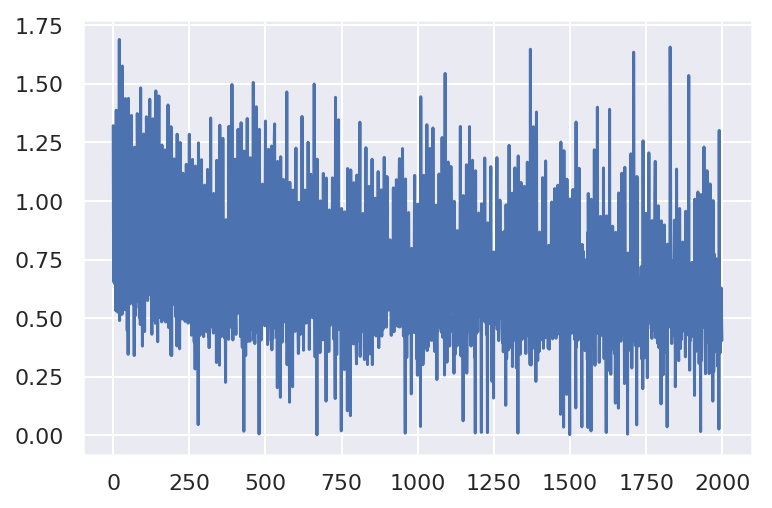

In [226]:
plt.plot(train_losses)

In [227]:
import torch
def get_loss(preds, targets):
    return nn.MSELoss()(torch.FloatTensor(preds), torch.FloatTensor(targets)).item()

In [228]:
targets, preds = get_predictions(model, trn_dl)
get_loss(preds, targets)

0.5317311882972717

In [229]:
from matrix_factorization.utils import get_predictions
targets, preds = get_predictions(model, val_dl)
get_loss(preds, targets)

0.8332489728927612

In [230]:
pd.DataFrame(np.stack([preds, targets]).T)

,0,1
0,1.711302,2.0
1,1.711302,2.0
2,1.711302,2.0
3,2.126541,2.0
4,2.126541,3.0
5,2.126541,3.0
6,2.141827,3.0
7,2.141827,1.0
8,2.141827,3.0
9,2.108677,1.0
